## Wrapper: test randomized smoothing

In [1]:
%load_ext autoreload
%autoreload 2

import torch 
from torch import nn

import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

import random_smooth as rs
from random_smooth import RandSmoothedClassifier
from base_classifier import ConvBase

# note: I didn't find clear instructions how to do the device handling correctly (?)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
base_classifier = ConvBase().to(device)
number_classes = 10
sigma = 1
batch_size = 128
epochs = 15

In [3]:
# --------------------

### Load and prepare data
(see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
# choose batch_size 1 for certification

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# --------------------

### Train the smoothed classifier
(see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [7]:
# init the smoothed classifier
classifier_smoothed = RandSmoothedClassifier(base_classifier=base_classifier, c=number_classes, sigma=sigma, device=device).to(device)

In [8]:
# choose a loss function and optimizer
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(classifier_smoothed.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(classifier_smoothed.parameters(), lr=0.001)

In [9]:
# set model to training mode
classifier_smoothed.train()
# base_classifier.train()
losses = []
accuracies = []
for epoch in range(epochs):
    print(f'Starting epoch {epoch}')
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # device handling
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + compute accuracy
        outputs = classifier_smoothed(inputs)
        # outputs = base_classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        accuracy = torch.mean((predicted == labels) * 1.0).item()
        accuracies.append(accuracy)
        
        # compute loss + backward
        loss = loss_func(outputs, labels)
        loss.backward()
        losses.append(loss.item())
        
        # optimization
        optimizer.step()

print('Finished training')

Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Finished training


In [10]:
PATH = './cifar_net.pth'
torch.save(classifier_smoothed.state_dict(), PATH)

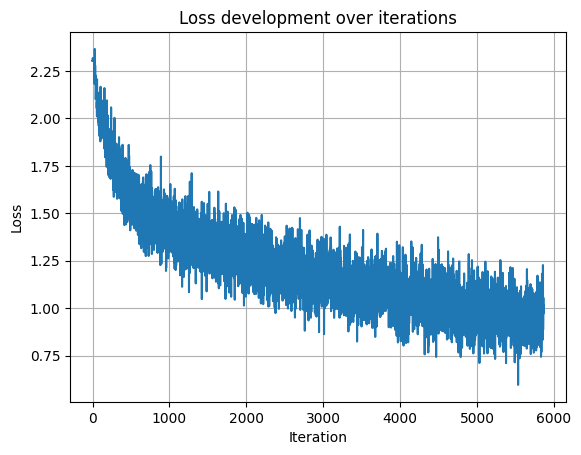

In [11]:
plt.plot(losses)
plt.title("Loss development over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Loss") 
plt.grid(True)
plt.show()

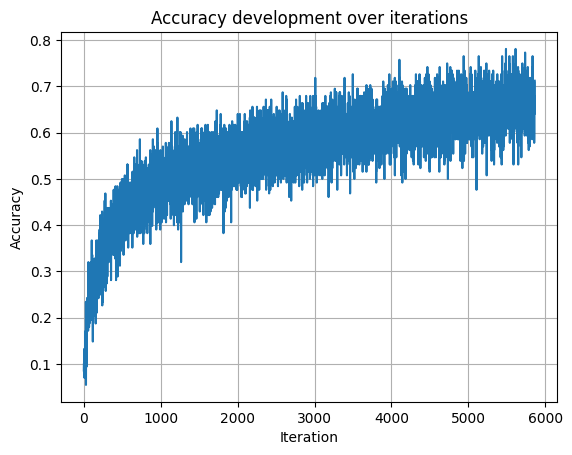

In [12]:
plt.plot(accuracies)
plt.title("Accuracy development over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Accuracy") 
plt.grid(True)
plt.show()

In [13]:
# --------------------

### Evaluate smoothed classifier
(see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [14]:
number_samples = 100
number_samples0 = 1000
alpha = 0.1
batch_size = batch_size

In [15]:
# load model
model = RandSmoothedClassifier(base_classifier=base_classifier, c=number_classes, sigma=sigma, device=device).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
correct_robust_radii = []
false_robust_radii = []
abstain = 0

for (image, label) in test_loader:
    # device handling
    image = image.to(device)
    label = label.to(device)
    
    prediction, robust_radius = model.certify(image, number_samples, number_samples0, alpha, batch_size)
    
    if prediction > -1:
        if prediction == label:
            correct_robust_radii.append(robust_radius)
        else:
            false_robust_radii.append(robust_radius)
    else:
        abstain += 1
        
correct = len(correct_robust_radii)
false = len(false_robust_radii)

# average robust radius
if len(correct_robust_radii) > 0:
    avg_radius = np.mean(correct_robust_radii)

print(f"{correct} correctly classified samples, average robust radius of {avg_radius}")
print(f"{false} falsely classified samples, {abstain} abstains")

5575 correctly classified samples, average robust radius of 1.378107564659515
2430 falsely classified samples, 1995 abstains
